In [2]:
import sys

from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from asap.annotation import ASAPNMF
from asap.data.dataloader import DataSet
from asap.util import topics
import asapc

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet(data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_path()
print(dl.inpath)
print(dl.outpath)

## for sim data
N = 1000
K = 10
P = 2000
X = pd.read_csv(dl.inpath+'_X.csv.gz')


dl.mtx = np.asmatrix(X)
dl.rows = ['c_'+str(i) for i in range(N) ]
dl.cols = ['g_'+str(i) for i in range(P) ]

logging.basicConfig(filename=dl.outpath+'_model.log',
						format='%(asctime)s %(levelname)-8s %(message)s',
						level=logging.INFO,
						datefmt='%Y-%m-%d %H:%M:%S')

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [3]:
asap = ASAPNMF(adata=dl)
asap.get_pbulk()
asap.pbulk_mat.shape

(336, 2000)

In [4]:
K = 10
nmfm = asapc.ASAPNMFDC(asap.pbulk_mat.T,K)
nmf = nmfm.run()

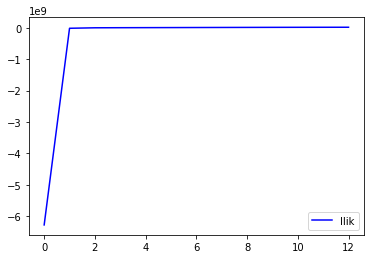

In [5]:
plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


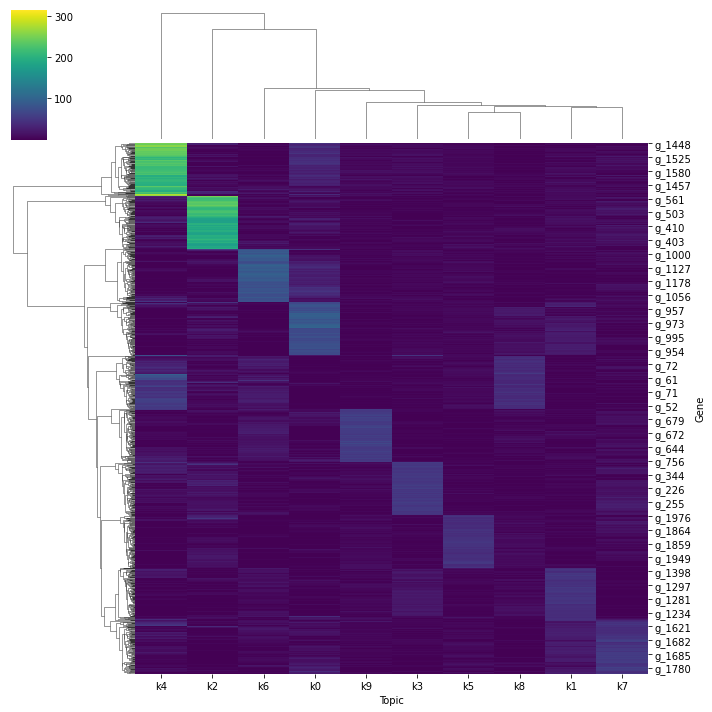

In [7]:
df_beta = pd.DataFrame(nmf.beta.T)

df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


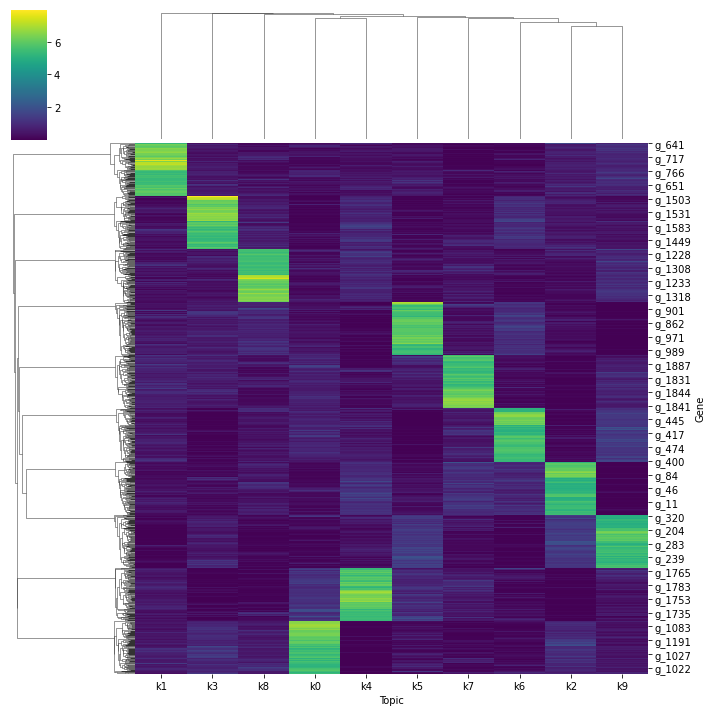

In [8]:
asap.factorize()
df_beta = pd.DataFrame(asap.model.Ebeta)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [9]:
regm = asapc.ASAPREG(dl.mtx.T,nmf.beta)
reg = regm.regress()

In [10]:
import umap
df_theta = pd.DataFrame(reg.corr)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,c_0,8,5.228225,6.301070
1,c_1,8,5.448014,6.828895
2,c_2,8,4.861090,7.183471
3,c_3,8,4.551130,6.647721
4,c_4,8,4.818034,7.516201
...,...,...,...,...
995,c_995,5,5.804407,2.825405
996,c_996,3,1.443376,-5.455759
997,c_997,5,6.576103,3.392223
998,c_998,5,5.318319,3.558631


In [ ]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_sc'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_sc',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from scNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

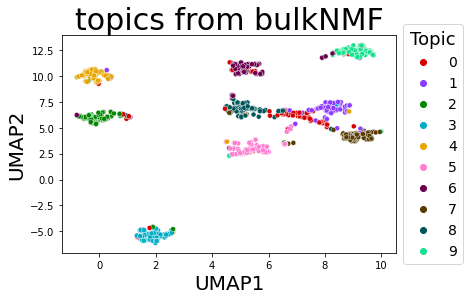

In [11]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [ ]:
df_scbeta = pd.DataFrame(asap.model.Ebeta)
df_bbeta = pd.DataFrame(asapsc.model.Ebeta)


sel_top_genes = list(np.unique(_topics.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.loc[i,sel_top_genes],df_scbeta.loc[j,sel_top_genes])[0,1])
    corr.append(cr)
sns.clustermap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [ ]:
df_top = _topics.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')



In [ ]:
df_top = _topics.get_topic_top_genes(df_bbeta.iloc[:,1:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')